# The material presented in this notebook is for using in Introduction to Deep Learning (CEE 690/ECE 590) course, Duke University, Fall 2019.

# __Transfer Learning__

<img src="traditional_ml_setup.png"  width="600" height="300">
<img src="transfer_learning_setup.png"  width="600" height="300">

* ### Train ResNet on MNIST and transfer feature extractor (model without last layer) to FashionMNIST
* ### Given a model pretrained from a large dataset and transfer the model parameters for another much smaller dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## __MNIST__

In [2]:
batch_size = 100
train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
train_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_set['mnist'] = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader['mnist'] = torch.utils.data.DataLoader(train_set['mnist'], batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['mnist'] = torch.utils.data.DataLoader(test_set['mnist'], batch_size=batch_size, shuffle=False, num_workers=0)

## __Model architecture__

In [3]:
class ResBlock(nn.Module):
    def __init__(self, n_channels):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn1 = nn.BatchNorm2d(n_channels)
        self.conv2 = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=3, stride=1, padding=1, bias=True)
        self.bn2 = nn.BatchNorm2d(n_channels)

    def forward(self, x):
        shortcut = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)) + shortcut)
        return x

class ResNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=hidden_channels, kernel_size=1, stride=1, padding=0, bias=True)
        self.res1 = ResBlock(hidden_channels)
        self.res2 = ResBlock(hidden_channels)
        self.classifier = nn.Linear(in_features=hidden_channels*7*7, out_features=out_channels)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.res1(x)
        x = F.max_pool2d(x, 2)
        x = self.res2(x)
        x = x.view(x.size(0),-1)
        x = self.classifier(x)
        return x

## __Define train() and test()__

In [4]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if batch_idx % (len(train_loader)//2) == 0:
            print('Train({})[{:.0f}%]: Loss: {:.4f}'.format(
                epoch, 100. * batch_idx / len(train_loader), train_loss/(batch_idx+1)))
    return

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print('Test({}): Loss: {:.4f}, Accuracy: {:.4f}%'.format(
        epoch, test_loss, acc))
    return acc

## __Define make_optimizer() and make_schedule__

In [5]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

In [6]:
seed = 1
device = 'cuda'
data_name = 'mnist'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 10
lr = 0.05
device = torch.device(device)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
in_channels = 1
hidden_channels = 16
out_channels = 10
model_mnist = ResNet(in_channels, hidden_channels, out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model_mnist, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
acc_0 = test(model_mnist, device, test_loader[data_name], criterion, 0)
acc = [acc_0]
for epoch in range(1, num_epochs + 1):
    train(model_mnist, device, train_loader[data_name], criterion, optimizer, epoch)
    acc_i = test(model_mnist, device, test_loader[data_name], criterion, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
    acc.append(acc_i)

Test(0): Loss: 2.3238, Accuracy: 10.9700%
Train(1)[0%]: Loss: 2.5630
Train(1)[50%]: Loss: 0.5175
Test(1): Loss: 0.0843, Accuracy: 97.4700%
Optimizer Learning rate: 0.0500
Train(2)[0%]: Loss: 0.0423
Train(2)[50%]: Loss: 0.0710
Test(2): Loss: 0.0522, Accuracy: 98.3900%
Optimizer Learning rate: 0.0500
Train(3)[0%]: Loss: 0.0389
Train(3)[50%]: Loss: 0.0545
Test(3): Loss: 0.0480, Accuracy: 98.5700%
Optimizer Learning rate: 0.0500
Train(4)[0%]: Loss: 0.0800
Train(4)[50%]: Loss: 0.0443
Test(4): Loss: 0.0399, Accuracy: 98.6900%
Optimizer Learning rate: 0.0500
Train(5)[0%]: Loss: 0.0167
Train(5)[50%]: Loss: 0.0366
Test(5): Loss: 0.0503, Accuracy: 98.4200%
Optimizer Learning rate: 0.0050
Train(6)[0%]: Loss: 0.0433
Train(6)[50%]: Loss: 0.0268
Test(6): Loss: 0.0301, Accuracy: 99.0100%
Optimizer Learning rate: 0.0050
Train(7)[0%]: Loss: 0.0288
Train(7)[50%]: Loss: 0.0248
Test(7): Loss: 0.0305, Accuracy: 98.9600%
Optimizer Learning rate: 0.0050
Train(8)[0%]: Loss: 0.0381
Train(8)[50%]: Loss: 0.0239


### __Learning Curve__

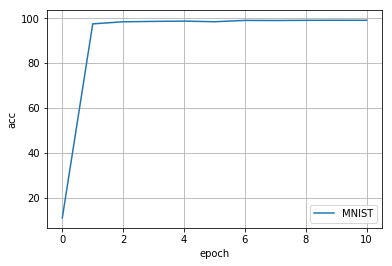

In [7]:
plt.figure()
plt.plot(acc, label='MNIST')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()

## __FashionMNIST__

### Randomly choose 500 points from FashionMNIST dataset

In [8]:
batch_size = 100
train_set,test_set,train_loader,test_loader = {},{},{},{}
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
train_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set['fashionmnist'] = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

data_size = 500
data_idx =  torch.randperm(len(train_set['fashionmnist']))
data_idx = data_idx[:data_size]
sub_dataset = torch.utils.data.Subset(train_set['fashionmnist'], data_idx)
train_loader['fashionmnist'] = torch.utils.data.DataLoader(sub_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['fashionmnist'] = torch.utils.data.DataLoader(test_set['fashionmnist'], batch_size=batch_size, shuffle=False, num_workers=0)

### __Transfer model parameters but leave out last layer (classifier)__

In [9]:
device = 'cuda'
data_name = 'fashionmnist'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 10
lr = 0.05
in_channels = 1
hidden_channels = 16
out_channels = 10

model_fashionmnist = ResNet(in_channels, hidden_channels, out_channels).to(device)
model_fashionmnist.load_state_dict(model_mnist.state_dict())
model_fashionmnist.classifier.reset_parameters()

criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model_fashionmnist, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
acc_0 = test(model_fashionmnist, device, test_loader[data_name], criterion, 0)
acc_transfer = [acc_0]
for epoch in range(1, num_epochs + 1):
    train(model_fashionmnist, device, train_loader[data_name], criterion, optimizer, epoch)
    acc_i = test(model_fashionmnist, device, test_loader[data_name], criterion, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
    acc_transfer.append(acc_i)

Test(0): Loss: 2.6087, Accuracy: 4.1500%
Train(1)[0%]: Loss: 2.6650
Train(1)[40%]: Loss: 2.2005
Train(1)[80%]: Loss: 1.7202
Test(1): Loss: 0.4560, Accuracy: 84.4100%
Optimizer Learning rate: 0.0500
Train(2)[0%]: Loss: 0.4180
Train(2)[40%]: Loss: 0.3284
Train(2)[80%]: Loss: 0.2717
Test(2): Loss: 0.1847, Accuracy: 95.8400%
Optimizer Learning rate: 0.0500
Train(3)[0%]: Loss: 0.1226
Train(3)[40%]: Loss: 0.1266
Train(3)[80%]: Loss: 0.1282
Test(3): Loss: 0.1680, Accuracy: 96.1200%
Optimizer Learning rate: 0.0500
Train(4)[0%]: Loss: 0.1262
Train(4)[40%]: Loss: 0.1059
Train(4)[80%]: Loss: 0.1016
Test(4): Loss: 0.1381, Accuracy: 96.3900%
Optimizer Learning rate: 0.0500
Train(5)[0%]: Loss: 0.0844
Train(5)[40%]: Loss: 0.0812
Train(5)[80%]: Loss: 0.0738
Test(5): Loss: 0.1323, Accuracy: 96.7600%
Optimizer Learning rate: 0.0050
Train(6)[0%]: Loss: 0.0661
Train(6)[40%]: Loss: 0.0565
Train(6)[80%]: Loss: 0.0614
Test(6): Loss: 0.1285, Accuracy: 96.8400%
Optimizer Learning rate: 0.0050
Train(7)[0%]: Los

### __No transfer and train from scratch__

In [10]:
model_fashionmnist = ResNet(in_channels, hidden_channels, out_channels).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(optimizer_name, model_fashionmnist, lr=lr, momentum=0, weight_decay=0)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.1)
acc_0 = test(model_fashionmnist, device, test_loader[data_name], criterion, 0)
acc_no_transfer = [acc_0]
for epoch in range(1, num_epochs + 1):
    train(model_fashionmnist, device, train_loader[data_name], criterion, optimizer, epoch)
    acc_i = test(model_fashionmnist, device, test_loader[data_name], criterion, epoch)
    scheduler.step()
    print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
    acc_no_transfer.append(acc_i)

Test(0): Loss: 2.3221, Accuracy: 10.3300%
Train(1)[0%]: Loss: 2.6134
Train(1)[40%]: Loss: 5.6417
Train(1)[80%]: Loss: 7.8579
Test(1): Loss: 4.9329, Accuracy: 18.7300%
Optimizer Learning rate: 0.0500
Train(2)[0%]: Loss: 8.2991
Train(2)[40%]: Loss: 6.1177
Train(2)[80%]: Loss: 4.7989
Test(2): Loss: 2.2950, Accuracy: 30.9400%
Optimizer Learning rate: 0.0500
Train(3)[0%]: Loss: 1.7270
Train(3)[40%]: Loss: 1.3897
Train(3)[80%]: Loss: 1.1832
Test(3): Loss: 1.4422, Accuracy: 64.5200%
Optimizer Learning rate: 0.0500
Train(4)[0%]: Loss: 0.6514
Train(4)[40%]: Loss: 0.5538
Train(4)[80%]: Loss: 0.6077
Test(4): Loss: 0.9991, Accuracy: 78.4800%
Optimizer Learning rate: 0.0500
Train(5)[0%]: Loss: 0.3334
Train(5)[40%]: Loss: 0.3915
Train(5)[80%]: Loss: 0.4329
Test(5): Loss: 0.7795, Accuracy: 79.1400%
Optimizer Learning rate: 0.0050
Train(6)[0%]: Loss: 0.4380
Train(6)[40%]: Loss: 0.3600
Train(6)[80%]: Loss: 0.3505
Test(6): Loss: 0.6148, Accuracy: 84.5600%
Optimizer Learning rate: 0.0050
Train(7)[0%]: Lo

### __Learning Curve__

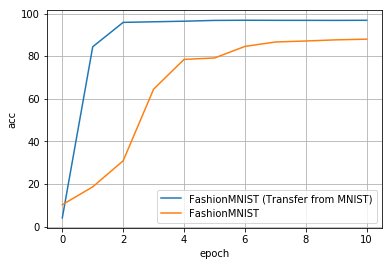

In [11]:
plt.figure()
plt.plot(acc_transfer, label='FashionMNIST (Transfer from MNIST)')
plt.plot(acc_no_transfer, label='FashionMNIST')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()